# Robust PCA Based Anomaly Detector

The goal is to detect which days the return were anomalous based on some sparse metric.  We should understand the anomalous behavior using several factos:
<ol>
    <li> Did S&amp;P 500 move because only large cap stocks moved?
    <li> Did a large number of S&amp;P 500 constituents move?
    <li> Given that markets are mean reverting, how long does this movement last?
</ol>

<p> There are several things to consider:
<ol>
    <li> What makes a S&amp;P 500 return anomalous? Is it an absolute/threshold value?      
    <li> Should we use the same threshold for each ticker or should we use a different ticker?
    <li> Given, markets are semi-efficient, especially large cap stocks should we use a moving average?
    <li> Should we use sector ETF with ARIMA type model or absolute value?
</ol>

In [475]:
import numpy as np
import os
import sys
import pandas as pd
from dateutil import parser
import scipy.sparse

from sklearn.metrics import confusion_matrix

import datetime
import time
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

#### FUNCTIONS TO LOAD S&P 500 DATA

In [579]:
def get_returns_daily_df(filename):
    """Load the data and calculate log return.  Remove the 
    first row because it will always be NaN."""
    df = pd.read_csv(filename) 
    df.set_index(df['Dates'], inplace=True)
    df.drop('Dates', axis=1, inplace=True)
    df_ret = np.log(df / df.shift())
    return df_ret.iloc[1:]

def train_test_split(df, training_pct, validation_pct):
    training_set_end_idx = int(df.shape[0] * training_pct)
    validation_set_end_idx = int(df.shape[0] * (training_pct+ validation_pct))
    m_training = df[0:training_set_end_idx].copy()
    m_validation = df[training_set_end_idx:validation_set_end_idx].copy()
    m_test = df[validation_set_end_idx:].copy()
    return m_training, m_validation, m_test

def set_anomalies(x, upperThreshold, lowerThreshold):
    anomaly = 0
    if ((x > 0) & (x < upperThreshold)) | ((x > lowerThreshold) & (x < 0)):
        anomaly = 0
    elif x >= upperThreshold:
        anomaly = 1
    elif x <= lowerThreshold:
        anomaly = 1
    return anomaly

def update_anomalies_column(x, upperThreshold, lowerThreshold):
    anomaly = 0
    if x >= upperThreshold:
        anomaly = 1
    elif x <= lowerThreshold:
        anomaly = -1
    else:
        anomaly = 0
    return anomaly

def get_sp500_anomalies(df, upperThreshold, lowerThreshold):
    df_anomalies = df.copy()
    df_anomalies.drop('Adj Close', axis=1, inplace=True)
    df_anomalies['Anomaly'] = df_anomalies['Return'].apply(set_anomalies, 
                                                           upperThreshold=upperThreshold, 
                                                           lowerThreshold=lowerThreshold)
    return df_anomalies

def load_matrices(root_dir, lam):
    file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_S.npz')
    sparse_matrix = scipy.sparse.load_npz(file_path)
    dense_matrix = sparse_matrix.todense()
    
    u_file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_U.dat')
    e_file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_E.dat')
    vt_file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_VT.dat')
    
    U = np.load(u_file_path)
    E = np.load(e_file_path)
    VT = np.load(vt_file_path)
    
    return sparse_matrix, dense_matrix, U, E, VT

def load_sparse_matrix(root_dir, lam):
    file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_S.npz')
    sparse_matrix = scipy.sparse.load_npz(file_path)
    dense_matrix = sparse_matrix.todense()
    return dense_matrix

def get_full_path_2_save(root_dir, filename):
    full_path = os.path.join(root_dir, filename)    
    return full_path

def get_output_root_dir(dataset_type, input_type):
    output_root_dir = BASE_OUTPUT_DIR
    full_path = os.path.join(os.path.join(BASE_OUTPUT_DIR, input_type), dataset_type)    
    return full_path

def get_sparse_df_from_matrix(S, sp500_anomalies):
    # set small entries to 0
    S[abs(S) < TICKER_ANOMALY_THRESHOLD] = 0        
    
    # number of non zero elements per day
    nnz = np.count_nonzero(S, axis=1)

    # calculate NNZ - number of non zero elements
    # increase or decrease on a daily basis
    S_df = pd.DataFrame(nnz)
    S_df.columns = ['NNZ']
    S_df.index = pd.to_datetime(sp500_anomalies.index)
    S_df['NNZ_PCT_CHGN'] = (S_df['NNZ']/S_df['NNZ'].shift() - 1)
    S_df.fillna(0, inplace=True)
    
    # to avoid daily fluctuations, we leverage moving average
    # because these are liquid stocks we only use a week, 5 trading days.
    # also calculate the fluctuations in these
    S_df['NNZ_MA_5D'] = S_df['NNZ'].rolling(5).mean()
    S_df.fillna(0, inplace=True)

    S_df['NNZ_MA_5D_CHGN'] = (S_df['NNZ_MA_5D']/S_df['NNZ_MA_5D'].shift() - 1)
    S_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    S_df.fillna(0, inplace=True)

    return S_df    

def get_sparse_dfs(input_type, lambda_multiplier, Y_training_anomalies, Y_validation_anomalies, Y_test_anomalies):
    output_root_dir = get_output_root_dir("training", input_type)
    S_training = load_sparse_matrix(output_root_dir, lambda_multiplier)
    S_training_df = get_sparse_df_from_matrix(S_training, Y_training_anomalies)

    output_root_dir = get_output_root_dir("validation", input_type)
    S_validation = load_sparse_matrix(output_root_dir, lambda_multiplier)
    S_validation_df = get_sparse_df_from_matrix(S_validation, Y_validation_anomalies)

    output_root_dir = get_output_root_dir("test", input_type)
    S_test = load_sparse_matrix(output_root_dir, lambda_multiplier)
    S_test_df = get_sparse_df_from_matrix(S_test, Y_test_anomalies)
    
    return S_training_df, S_validation_df, S_test_df
        

def get_train_val_test(S_training_df, S_validation_df, S_test_df):
    X_train = S_training_df.iloc[4:,].copy().as_matrix()
    y_train = Y_training_anomalies.iloc[4:,1].copy().as_matrix()
    y_train = np.reshape(y_train,-1)

    X_val = S_validation_df.iloc[4:,].copy().as_matrix()
    y_val = Y_validation_anomalies.iloc[4:,1].copy().as_matrix()
    y_val = np.reshape(y_val,-1)

    X_test = S_test_df.iloc[4:,].copy().as_matrix()
    y_test = Y_test_anomalies.iloc[4:,1].copy().as_matrix()
    y_test = np.reshape(y_test,-1)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [477]:
SP500_INDEX_LEVELS = r'C:\phd\rpca\input\prices\GSPC.csv'
SP500_ANOMALY_THRESHOLD = 0.015
TICKER_ANOMALY_THRESHOLD = 0.015
BASE_OUTPUT_DIR = r'C:\phd\rpca\output'

In [478]:
# Decide what is an anomaly, by labeling days with 
# absolute return above a threshold as anomalies
sp500_df = pd.read_csv(SP500_INDEX_LEVELS)
sp500_df = sp500_df.set_index('Date')
sp500_df.index = pd.to_datetime(sp500_df.index)
df_ = sp500_df[['Adj Close']].copy()
df_returns = np.log(df_/df_.shift())
sp500_returns_df = df_returns.iloc[1:].copy()
sp500_returns_df.columns = ['Return']
sp500_returns_df['Adj Close'] = df_.loc[sp500_returns_df.index]['Adj Close']

# Split the data set and decide what is an anomaly
split_pct = 0.66
validation_pct = 0.17
# X_training_df, X_validation_df, X_test_df = train_test_split(constituents_returns_df, split_pct, validation_pct)
sp500_training_df, sp500_validation_df, sp500_test_df = train_test_split(sp500_returns_df, split_pct, validation_pct)

In [479]:
# We now have labeling to see if the day was anomalous or not
upperThreshold = SP500_ANOMALY_THRESHOLD
lowerThreshold = -1 * SP500_ANOMALY_THRESHOLD
Y_training_anomalies = get_sp500_anomalies(sp500_training_df, upperThreshold, lowerThreshold)
Y_validation_anomalies = get_sp500_anomalies(sp500_validation_df, upperThreshold, lowerThreshold)
Y_test_anomalies = get_sp500_anomalies(sp500_test_df, upperThreshold, lowerThreshold)

print('-----------------------------------------------------------------------')
print('Training S&P 500 instances = %d' % Y_training_anomalies.shape[0])
print("\tDECREASE of > -2%% = %d" % np.sum(Y_training_anomalies['Anomaly'] < 0))
print("\tNO CHANGE between -2%% and +2%% = %d" % np.sum(Y_training_anomalies['Anomaly'] == 0))
print("\tINCREASE of > 2%% = %d" % np.sum(Y_training_anomalies['Anomaly'] > 0))

print('-----------------------------------------------------------------------')
print('Validation S&P 500 instances = %d' % Y_validation_anomalies.shape[0])
print("\tDECREASE of > -2%% = %d" % np.sum(Y_validation_anomalies['Anomaly'] < 0))
print("\tNO CHANGE between -2%% and +2%% = %d" % np.sum(Y_validation_anomalies['Anomaly'] == 0))
print("\tINCREASE of > 2%% = %d" % np.sum(Y_validation_anomalies['Anomaly'] > 0))

print('-----------------------------------------------------------------------')
print('Test S&P 500 instances = %d' % Y_test_anomalies.shape[0])
print("\tDECREASE of > -2%% = %d" % np.sum(Y_test_anomalies['Anomaly'] < 0))
print("\tNO CHANGE between -2%% and +2%% = %d" % np.sum(Y_test_anomalies['Anomaly'] == 0))
print("\tINCREASE of > 2%% = %d" % np.sum(Y_test_anomalies['Anomaly'] > 0))

-----------------------------------------------------------------------
Training S&P 500 instances = 1954
	DECREASE of > -2% = 0
	NO CHANGE between -2% and +2% = 1611
	INCREASE of > 2% = 343
-----------------------------------------------------------------------
Validation S&P 500 instances = 503
	DECREASE of > -2% = 0
	NO CHANGE between -2% and +2% = 467
	INCREASE of > 2% = 36
-----------------------------------------------------------------------
Test S&P 500 instances = 504
	DECREASE of > -2% = 0
	NO CHANGE between -2% and +2% = 474
	INCREASE of > 2% = 30


### Exploratory Analysis of S&P Returns Distribution 

In [480]:
# normal_mask = Y_training_anomalies['Anomaly'] == 0
# anomaly_mask = ~normal_mask
# plt.scatter(Y_training_anomalies.index[normal_mask], Y_training_anomalies.loc[normal_mask]['Return'], color="green")
# plt.scatter(Y_training_anomalies.index[anomaly_mask], Y_training_anomalies.loc[anomaly_mask]['Return'], color="red")

Return
(-0.0947, -0.072]      AxesSubplot(0.125,0.125;0.775x0.755)
(-0.072, -0.0493]      AxesSubplot(0.125,0.125;0.775x0.755)
(-0.0493, -0.0266]     AxesSubplot(0.125,0.125;0.775x0.755)
(-0.0266, -0.00391]    AxesSubplot(0.125,0.125;0.775x0.755)
(-0.00391, 0.0188]     AxesSubplot(0.125,0.125;0.775x0.755)
(0.0188, 0.0415]       AxesSubplot(0.125,0.125;0.775x0.755)
(0.0415, 0.0642]       AxesSubplot(0.125,0.125;0.775x0.755)
(0.0642, 0.0869]       AxesSubplot(0.125,0.125;0.775x0.755)
(0.0869, 0.11]         AxesSubplot(0.125,0.125;0.775x0.755)
Name: Return, dtype: object

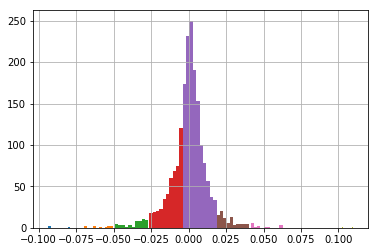

In [481]:
# Bin the data frame by "Return" with 10 bins...
bins = np.linspace(sp500_training_df.Return.min(), sp500_training_df.Return.max(), 10)
groups = sp500_training_df.groupby(pd.cut(sp500_training_df.Return, bins))
groups['Return'].hist()

In [482]:
print(groups['Return'].count())

Return
(-0.0947, -0.072]         3
(-0.072, -0.0493]        10
(-0.0493, -0.0266]       52
(-0.0266, -0.00391]     480
(-0.00391, 0.0188]     1303
(0.0188, 0.0415]         87
(0.0415, 0.0642]         14
(0.0642, 0.0869]          2
(0.0869, 0.11]            2
Name: Return, dtype: int64


#### PLOT THE TARGET ALONG WITH S&P 500 INDEX LEVELS

In [483]:
def plot_sp500(training_df, validation_df, test_df):
    fig, axes = plt.subplots(ncols=3, figsize = (20, 6))
    axes[0].plot(training_df.index, training_df['Adj Close'])
    axes[0].set_title('Training S&P 500 Adj Close')
    axes[0].xaxis_date()
    axes[0].set_ylim(600, 3000)
    date_format = mdates.DateFormatter('%m/%y')
    axes[0].xaxis.set_major_formatter(date_format)

    axes[1].plot(validation_df.index, validation_df['Adj Close'])
    axes[1].set_title('Validation S&P 500 Adj Close')
    axes[1].xaxis_date()
    axes[1].set_ylim(600, 3000)
    axes[1].xaxis.set_major_formatter(date_format)

    axes[2].plot(test_df.index, test_df['Adj Close'])
    axes[2].set_title('Test S&P 500 Adj Close')
    axes[2].xaxis_date()
    axes[2].set_ylim(600, 3000)
    axes[2].xaxis.set_major_formatter(date_format)
    
def plot_sp500_anomalies(training_df, validation_df, test_df):
    fig, axes = plt.subplots(ncols=3, figsize = (20, 6))
    
    normal_mask = training_df['Anomaly'] == 0
    anomaly_mask = ~normal_mask
    axes[0].scatter(training_df.index[normal_mask], training_df.loc[normal_mask]['Return'], color="green")
    axes[0].scatter(training_df.index[anomaly_mask], training_df.loc[anomaly_mask]['Return'], color="red")
    axes[0].set_title('Training S&P 500 Anomalies')
    axes[0].set_ylim(-0.10, 0.10)
    axes[0].xaxis_date()
    date_format = mdates.DateFormatter('%m/%y')
    axes[0].xaxis.set_major_formatter(date_format)

    normal_mask = validation_df['Anomaly'] == 0
    anomaly_mask = ~normal_mask
    axes[1].scatter(validation_df.index[normal_mask], validation_df.loc[normal_mask]['Return'], color="green")
    axes[1].scatter(validation_df.index[anomaly_mask], validation_df.loc[anomaly_mask]['Return'], color="red")
    axes[1].set_title('Validation S&P 500 Anomalies')
    axes[1].set_ylim(-0.10, 0.10)
    axes[1].xaxis_date()
    axes[1].xaxis.set_major_formatter(date_format)

    normal_mask = test_df['Anomaly'] == 0
    anomaly_mask = ~normal_mask
    axes[2].scatter(test_df.index[normal_mask], test_df.loc[normal_mask]['Return'], color="green")
    axes[2].scatter(test_df.index[anomaly_mask], test_df.loc[anomaly_mask]['Return'], color="red")
    axes[2].set_title('Test S&P 500 Anomalies')
    axes[2].set_ylim(-0.10, 0.10)
    axes[2].xaxis_date()
    axes[2].xaxis.set_major_formatter(date_format)

def plot_nnz_pct_chgn(S_training_df, S_validation_df, S_test_df):
    fig, axes = plt.subplots(ncols=3, figsize = (20, 6))
    
    normal_mask = abs(S_training_df['NNZ_PCT_CHGN']) <= 0.05
    anomaly_mask = ~normal_mask
    axes[0].scatter(S_training_df.index[normal_mask], S_training_df.loc[normal_mask]['NNZ_PCT_CHGN'], color="green")
    axes[0].scatter(S_training_df.index[anomaly_mask], S_training_df.loc[anomaly_mask]['NNZ_PCT_CHGN'], color="red")
    axes[0].set_title('Training NNZ_PCT_CHGN')
    axes[0].set_ylim(-0.10, 0.10)
    axes[0].xaxis_date()
    date_format = mdates.DateFormatter('%m/%y')
    axes[0].xaxis.set_major_formatter(date_format)

    normal_mask = abs(S_validation_df['NNZ_PCT_CHGN']) <= 0.05
    anomaly_mask = ~normal_mask
    axes[1].scatter(S_validation_df.index[normal_mask], S_validation_df.loc[normal_mask]['NNZ_PCT_CHGN'], color="green")
    axes[1].scatter(S_validation_df.index[anomaly_mask], S_validation_df.loc[anomaly_mask]['NNZ_PCT_CHGN'], color="red")
    axes[1].set_title('Validation NNZ_PCT_CHGN')
    axes[1].set_ylim(-0.10, 0.10)
    axes[1].xaxis_date()
    axes[1].xaxis.set_major_formatter(date_format)

    normal_mask = abs(S_test_df['NNZ_PCT_CHGN']) <= 0.05
    anomaly_mask = ~normal_mask
    axes[2].scatter(S_test_df.index[normal_mask], S_test_df.loc[normal_mask]['NNZ_PCT_CHGN'], color="green")
    axes[2].scatter(S_test_df.index[anomaly_mask], S_test_df.loc[anomaly_mask]['NNZ_PCT_CHGN'], color="red")
    axes[2].set_title('Test NNZ_PCT_CHGN')
    axes[2].set_ylim(-0.10, 0.10)
    axes[2].xaxis_date()
    axes[2].xaxis.set_major_formatter(date_format)
    
    
    
def plot_nnz(S_training_df, S_validation_df, S_test_df):
    fig, axes = plt.subplots(ncols=3, figsize = (20, 6))
    
    axes[0].plot(S_training_df.index, S_training_df['NNZ'])    
    axes[0].set_title('Training Sparse NNZ')
    axes[0].set_ylim(0, 400)
    axes[0].xaxis_date()
    date_format = mdates.DateFormatter('%m/%y')
    axes[0].xaxis.set_major_formatter(date_format)

    axes[1].plot(S_validation_df.index, S_validation_df['NNZ'])    
    axes[1].set_title('Validation S&P 500 Anomalies')
    axes[1].set_ylim(0, 400)
    axes[1].xaxis_date()
    axes[1].xaxis.set_major_formatter(date_format)

    axes[2].plot(S_test_df.index, S_test_df['NNZ'])    
    axes[2].set_title('Test S&P 500 Anomalies')
    axes[2].set_ylim(0, 400)
    axes[2].xaxis_date()
    axes[2].xaxis.set_major_formatter(date_format)    
    
    

### PLOT OF RETUNRS FOR A LAMBDA

In [486]:
some_lambda_multiplier = 1
S_training_df, S_validation_df, S_test_df = get_sparse_dfs("returns", 
                                                            some_lambda_multiplier, 
                                                            Y_training_anomalies, 
                                                            Y_validation_anomalies, 
                                                            Y_test_anomalies)


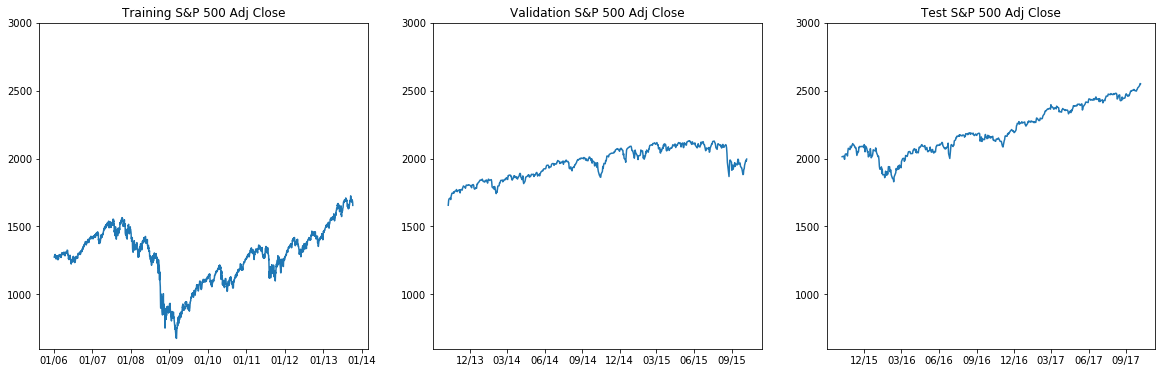

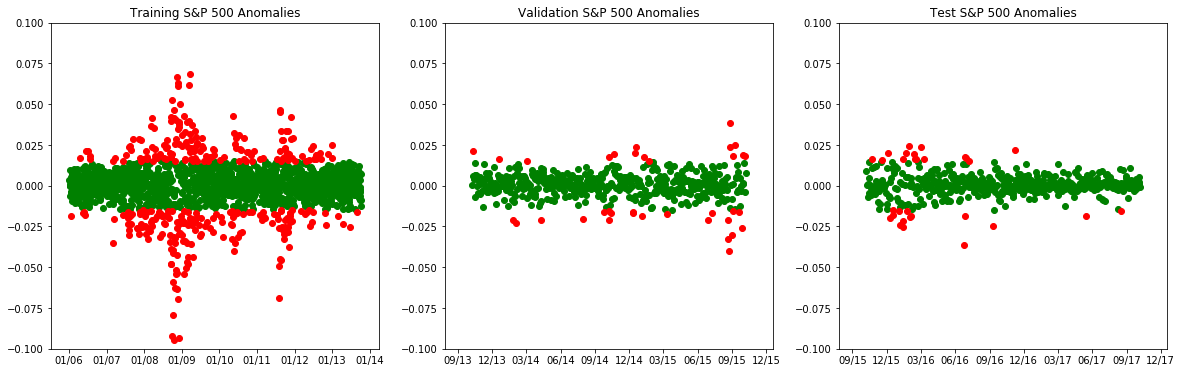

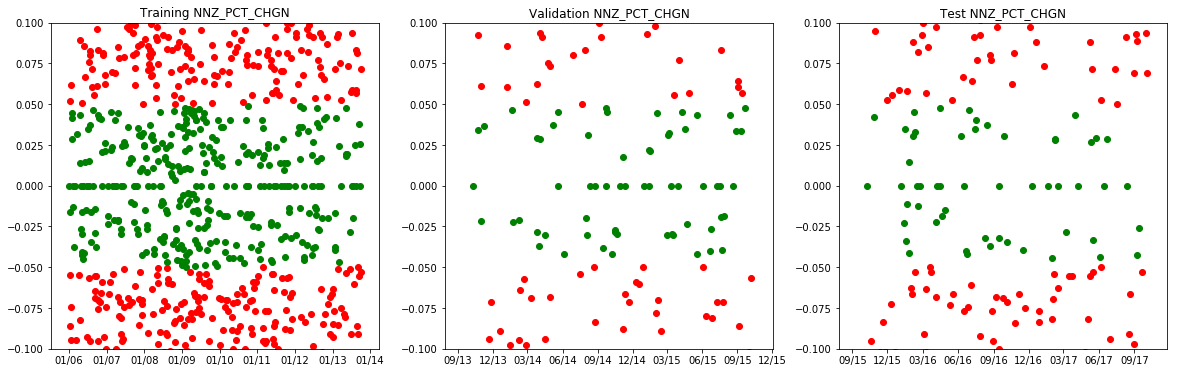

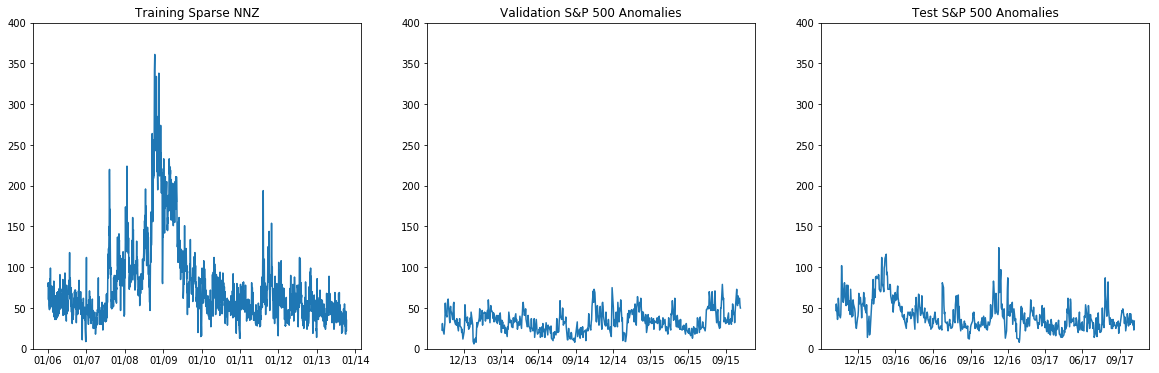

In [487]:
plot_sp500(sp500_training_df, sp500_validation_df, sp500_test_df)
plot_sp500_anomalies(Y_training_anomalies, Y_validation_anomalies, Y_test_anomalies)
plot_nnz_pct_chgn(S_training_df, S_validation_df, S_test_df)
plot_nnz(S_training_df, S_validation_df, S_test_df)

#### $1^{ST}$ ORDER INPUT - RETURNS - DETECTING ANOMALIES

In [488]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

In [489]:
def get_y_training_pred(X_train, nnzPctChgn, nnzMa5dChgn):
    y_train = []
    for i in np.arange(X_train.shape[0]):
        # 0 element is NNZ
        # 1 element is NNZ_PCT_CHGN
        # 2 element is NNZ_MA_5D
        # 3 element is NNZ_MA_5D_CHGN
        if abs(X_train[i, 1]) > nnzPctChgn or abs(X_train[i, 3]) > nnzMa5dChgn:
            y_train.append(1)
        else:
            y_train.append(0)
    return np.asarray(y_train)

def calculate_scores(cm):
    TP = cm[1,1]
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]            

    precision = TP/(TP+FP)
    recall = TP/(TP+FN)

    f1 = None
    if (precision == 0 and recall == 0):
        f1 = 0
    else:
        f1 = 2*(precision*recall)/(precision+recall)
    
    return TP, TN, FP, FN, precision, recall, f1

#### ALGORITHM - CREATES RETURNS RESULT DATAFRAME 

In [509]:
input_types = ["returns"]
dataset_types = ["training", "validation", "test"]
lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10]

for input_type in input_types:
    print("-----------------------------------------------------------------------------")
    print("%s" % input_type)
    
    result_df = pd.DataFrame(columns= ['Lambda', 'nnzPctChgn', 'nnzMa5dChgn', 'Precision', 'Recall', 'F1', 'TP', 'FP', 'TN', 'FN'])
    row_idx = 0
    for lambda_multiplier in lam_list:
        print("Processing lambda = %.5f" % lambda_multiplier)
        S_training_df, S_validation_df, S_test_df = get_sparse_dfs(input_type, 
                                                                   lambda_multiplier, 
                                                                   Y_training_anomalies, 
                                                                   Y_validation_anomalies, 
                                                                   Y_test_anomalies)
        X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test(S_training_df.copy(), 
                                                                            S_validation_df.copy(), 
                                                                            S_test_df.copy())        
                    
        for nnzPctChgn in np.linspace(-1.0, 1.0, num=51):
            for nnzMa5dChgn in np.linspace(-1.0, 1.0, num=51):
                y_training_pred = get_y_training_pred(X_train, nnzPctChgn, nnzMa5dChgn)
                cm = confusion_matrix(y_train, y_training_pred)
                TP, TN, FP, FN, precision, recall, f1 = calculate_scores(cm)

                result_df.loc[row_idx] = [lambda_multiplier, nnzPctChgn, nnzMa5dChgn, precision, recall, f1, TP, FP, TN, FN]
                row_idx = row_idx + 1

    # save the returns result data frame
    result_df.to_csv(r"C:\phd\rpca\debug\returns_result_df.csv")

-----------------------------------------------------------------------------
returns
Processing lambda = 0.05000
Processing lambda = 0.05260
Processing lambda = 0.05560
Processing lambda = 0.05880
Processing lambda = 0.06250
Processing lambda = 0.06670
Processing lambda = 0.07140
Processing lambda = 0.07690
Processing lambda = 0.08330
Processing lambda = 0.09090
Processing lambda = 0.10000
Processing lambda = 0.11110
Processing lambda = 0.12500
Processing lambda = 0.14290
Processing lambda = 0.16670
Processing lambda = 0.20000
Processing lambda = 0.25000
Processing lambda = 0.33000
Processing lambda = 0.50000
Processing lambda = 1.00000
Processing lambda = 2.00000
Processing lambda = 3.00000
Processing lambda = 4.00000
Processing lambda = 5.00000
Processing lambda = 6.00000
Processing lambda = 7.00000
Processing lambda = 8.00000
Processing lambda = 9.00000
Processing lambda = 10.00000


<hr/>

## Plot of Symmetrical KL-Divergence for a $\lambda$

In [492]:
some_lambda_multiplier = 1
S_training_df, S_validation_df, S_test_df = get_sparse_dfs("symmetrical-kl-divergence", 
                                                            some_lambda_multiplier, 
                                                            Y_training_anomalies, 
                                                            Y_validation_anomalies, 
                                                            Y_test_anomalies)


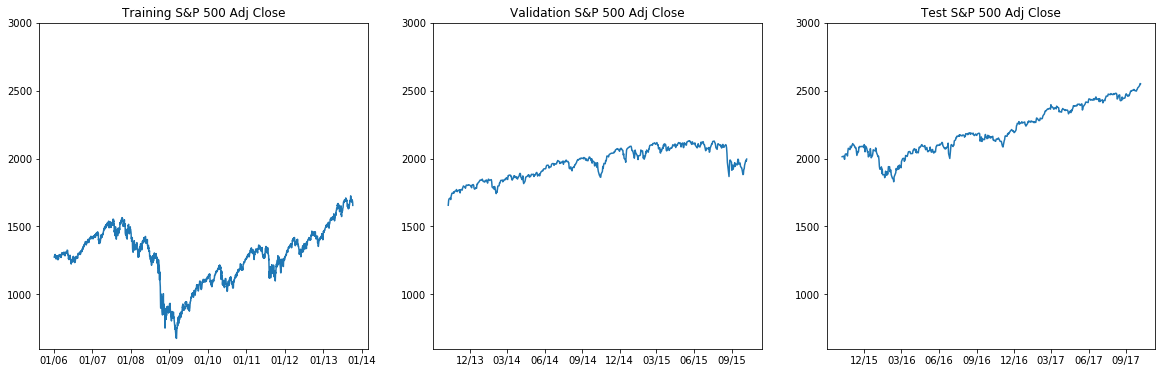

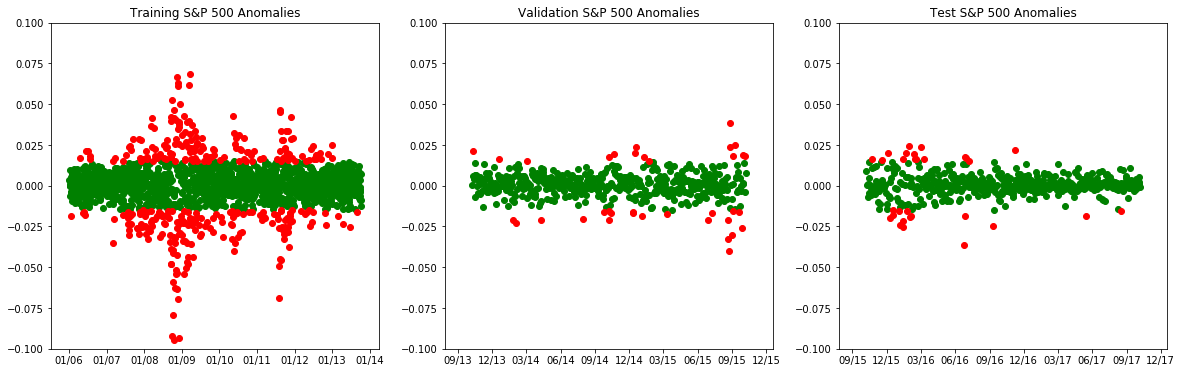

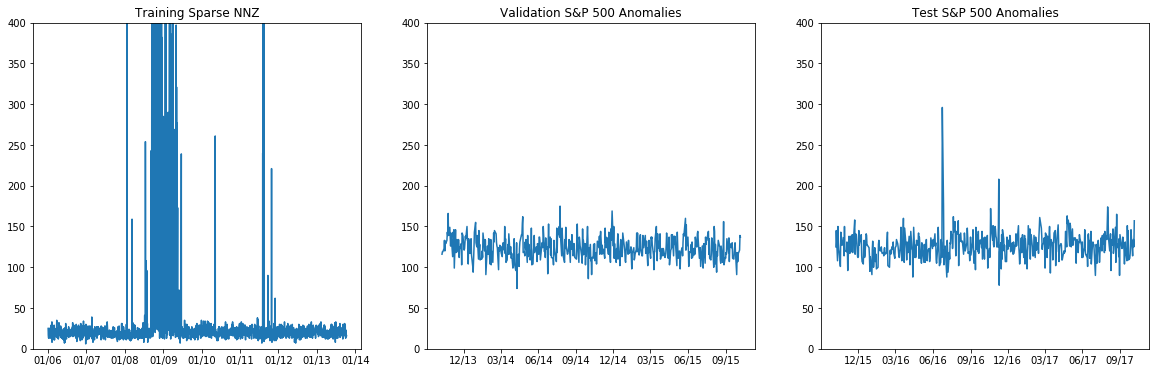

In [495]:
plot_sp500(sp500_training_df, sp500_validation_df, sp500_test_df)
plot_sp500_anomalies(Y_training_anomalies, Y_validation_anomalies, Y_test_anomalies)
# plot_nnz_pct_chgn(S_training_df, S_validation_df, S_test_df)
plot_nnz(S_training_df, S_validation_df, S_test_df)

#### $2^{ND}$ ORDER INPUT - SYMMETRICAL KL-DIVERGENCE - DETECTING ANOMALIES

In [508]:
input_types = ["symmetrical-kl-divergence"]
dataset_types = ["training", "validation", "test"]
lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10]

for input_type in input_types:
    print("-----------------------------------------------------------------------------")
    print("%s" % input_type)
    
    result_df = pd.DataFrame(columns= ['Lambda', 'nnzPctChgn', 'nnzMa5dChgn', 'Precision', 'Recall', 'F1', 'TP', 'FP', 'TN', 'FN'])
    row_idx = 0
    for lambda_multiplier in lam_list:
        print("Processing lambda = %.5f" % lambda_multiplier)
        S_training_df, S_validation_df, S_test_df = get_sparse_dfs(input_type, 
                                                                   lambda_multiplier, 
                                                                   Y_training_anomalies, 
                                                                   Y_validation_anomalies, 
                                                                   Y_test_anomalies)
        X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test(S_training_df.copy(), 
                                                                            S_validation_df.copy(), 
                                                                            S_test_df.copy())        
                    
        for nnzPctChgn in np.linspace(-1.0, 1.0, num=51):
            for nnzMa5dChgn in np.linspace(-1.0, 1.0, num=51):
                y_training_pred = get_y_training_pred(X_train, nnzPctChgn, nnzMa5dChgn)
                cm = confusion_matrix(y_train, y_training_pred)
                TP, TN, FP, FN, precision, recall, f1 = calculate_scores(cm)

                result_df.loc[row_idx] = [lambda_multiplier, nnzPctChgn, nnzMa5dChgn, precision, recall, f1, TP, FP, TN, FN]
                row_idx = row_idx + 1

    # save the returns result data frame
    result_df.to_csv(r"C:\phd\rpca\debug\symmetrical_kl_divergence_result_df.csv")

-----------------------------------------------------------------------------
symmetrical-kl-divergence
Processing lambda = 0.05000


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in longlong_scalars


Processing lambda = 0.05260
Processing lambda = 0.05560
Processing lambda = 0.05880
Processing lambda = 0.06250
Processing lambda = 0.06670
Processing lambda = 0.07140
Processing lambda = 0.07690
Processing lambda = 0.08330
Processing lambda = 0.09090
Processing lambda = 0.10000
Processing lambda = 0.11110
Processing lambda = 0.12500
Processing lambda = 0.14290
Processing lambda = 0.16670
Processing lambda = 0.20000
Processing lambda = 0.25000
Processing lambda = 0.33000
Processing lambda = 0.50000
Processing lambda = 1.00000
Processing lambda = 2.00000
Processing lambda = 3.00000
Processing lambda = 4.00000
Processing lambda = 5.00000
Processing lambda = 6.00000
Processing lambda = 7.00000
Processing lambda = 8.00000
Processing lambda = 9.00000
Processing lambda = 10.00000


<hr>

## Plot of <font color="red">Asymmetrical</font> KL-Divergence for a $\lambda$

In [512]:
some_lambda_multiplier = 1
S_training_df, S_validation_df, S_test_df = get_sparse_dfs("asymmetrical-kl-divergence", 
                                                            some_lambda_multiplier, 
                                                            Y_training_anomalies, 
                                                            Y_validation_anomalies, 
                                                            Y_test_anomalies)

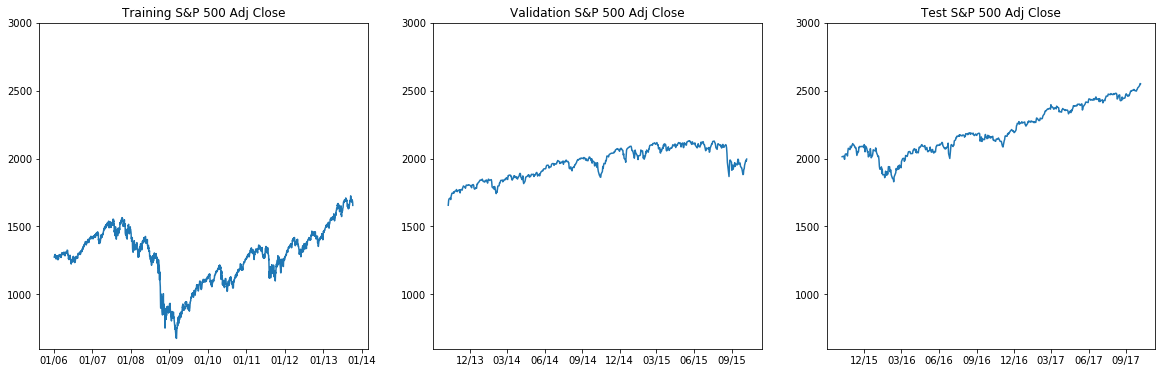

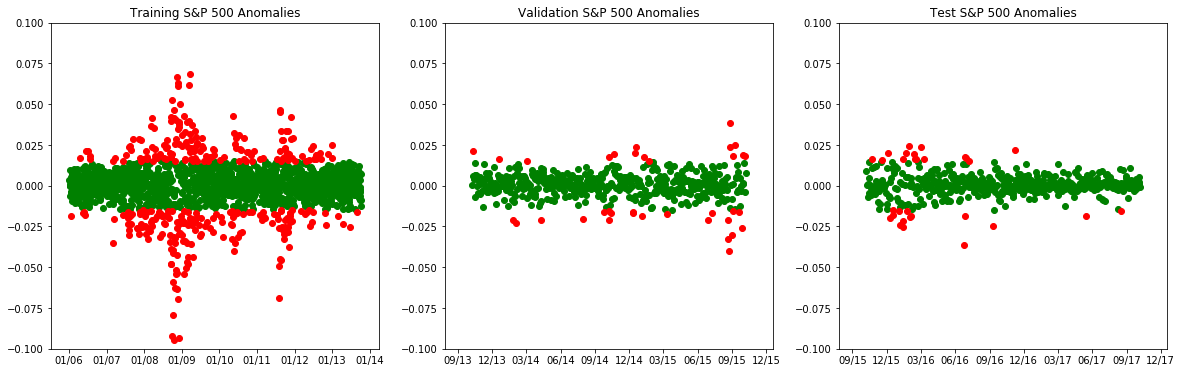

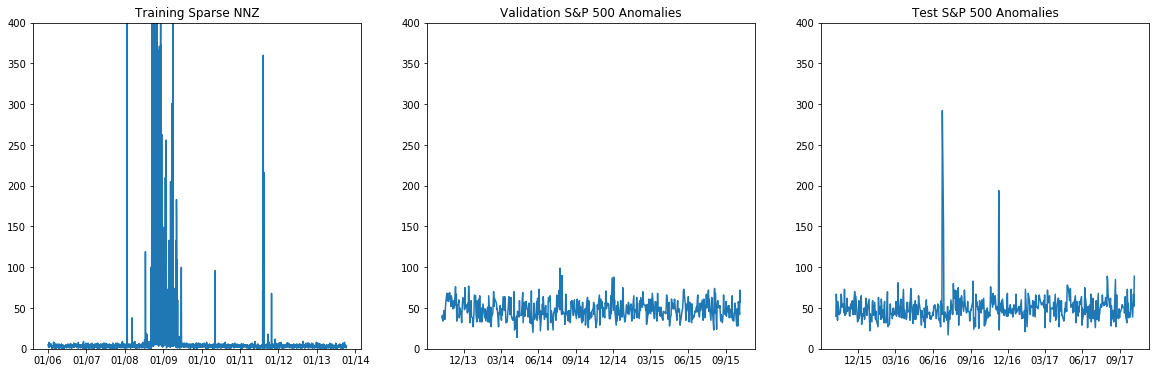

In [513]:
plot_sp500(sp500_training_df, sp500_validation_df, sp500_test_df)
plot_sp500_anomalies(Y_training_anomalies, Y_validation_anomalies, Y_test_anomalies)
# plot_nnz_pct_chgn(S_training_df, S_validation_df, S_test_df)
plot_nnz(S_training_df, S_validation_df, S_test_df)

#### $2^{ND}$ ORDER INPUT - <font color="red">ASYMMETRICAL</font> KL-DIVERGENCE - DETECTING ANOMALIES

In [514]:
input_types = ["asymmetrical-kl-divergence"]
dataset_types = ["training", "validation", "test"]
lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10]

for input_type in input_types:
    print("-----------------------------------------------------------------------------")
    print("%s" % input_type)
    
    result_df = pd.DataFrame(columns= ['Lambda', 'nnzPctChgn', 'nnzMa5dChgn', 'Precision', 'Recall', 'F1', 'TP', 'FP', 'TN', 'FN'])
    row_idx = 0
    for lambda_multiplier in lam_list:
        print("Processing lambda = %.5f" % lambda_multiplier)
        S_training_df, S_validation_df, S_test_df = get_sparse_dfs(input_type, 
                                                                   lambda_multiplier, 
                                                                   Y_training_anomalies, 
                                                                   Y_validation_anomalies, 
                                                                   Y_test_anomalies)
        X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test(S_training_df.copy(), 
                                                                            S_validation_df.copy(), 
                                                                            S_test_df.copy())        
                    
        for nnzPctChgn in np.linspace(-1.0, 1.0, num=51):
            for nnzMa5dChgn in np.linspace(-1.0, 1.0, num=51):
                y_training_pred = get_y_training_pred(X_train, nnzPctChgn, nnzMa5dChgn)
                cm = confusion_matrix(y_train, y_training_pred)
                TP, TN, FP, FN, precision, recall, f1 = calculate_scores(cm)

                result_df.loc[row_idx] = [lambda_multiplier, nnzPctChgn, nnzMa5dChgn, precision, recall, f1, TP, FP, TN, FN]
                row_idx = row_idx + 1

    # save the returns result data frame
    result_df.to_csv(r"C:\phd\rpca\debug\asymmetrical_kl_divergence_result_df.csv")

-----------------------------------------------------------------------------
asymmetrical-kl-divergence
Processing lambda = 0.05000
Processing lambda = 0.05260
Processing lambda = 0.05560
Processing lambda = 0.05880
Processing lambda = 0.06250
Processing lambda = 0.06670
Processing lambda = 0.07140
Processing lambda = 0.07690
Processing lambda = 0.08330
Processing lambda = 0.09090
Processing lambda = 0.10000
Processing lambda = 0.11110
Processing lambda = 0.12500
Processing lambda = 0.14290
Processing lambda = 0.16670
Processing lambda = 0.20000
Processing lambda = 0.25000
Processing lambda = 0.33000
Processing lambda = 0.50000
Processing lambda = 1.00000
Processing lambda = 2.00000
Processing lambda = 3.00000
Processing lambda = 4.00000


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in longlong_scalars


Processing lambda = 5.00000
Processing lambda = 6.00000
Processing lambda = 7.00000
Processing lambda = 8.00000
Processing lambda = 9.00000
Processing lambda = 10.00000


<hr>

## Plot of <font color="red">Euclidean Distance</font> for a $\lambda$

In [516]:
some_lambda_multiplier = 1
S_training_df, S_validation_df, S_test_df = get_sparse_dfs("euclidean-distances", 
                                                            some_lambda_multiplier, 
                                                            Y_training_anomalies, 
                                                            Y_validation_anomalies, 
                                                            Y_test_anomalies)

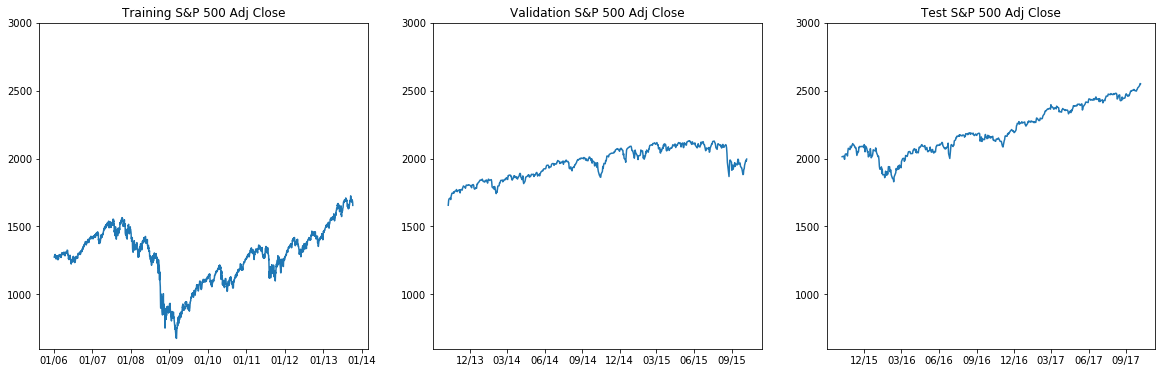

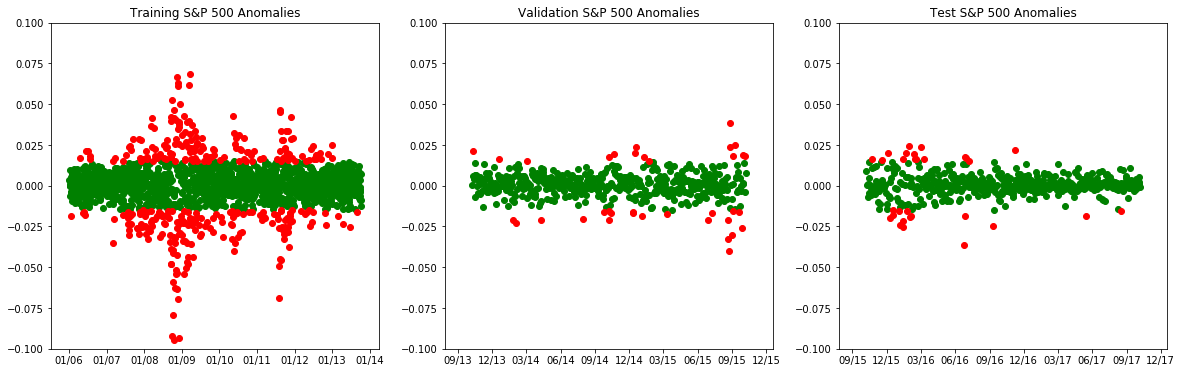

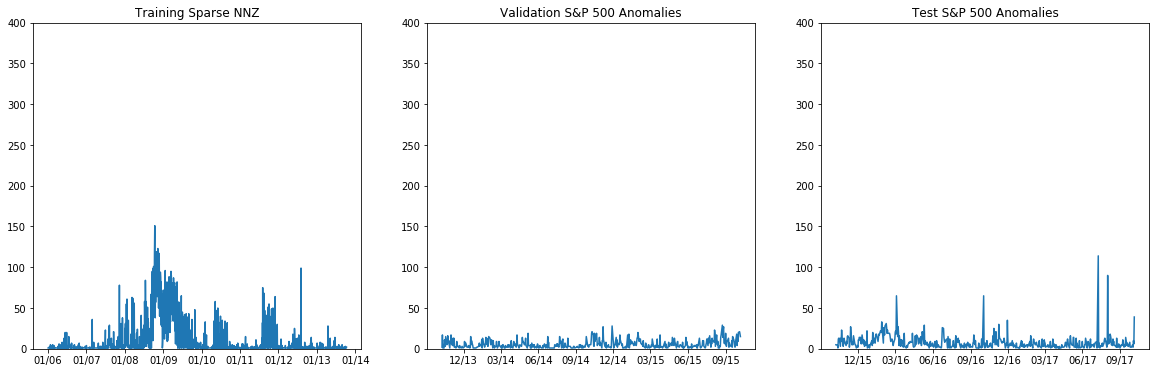

In [517]:
plot_sp500(sp500_training_df, sp500_validation_df, sp500_test_df)
plot_sp500_anomalies(Y_training_anomalies, Y_validation_anomalies, Y_test_anomalies)
# plot_nnz_pct_chgn(S_training_df, S_validation_df, S_test_df)
plot_nnz(S_training_df, S_validation_df, S_test_df)

#### $2^{ND}$ ORDER INPUT - <font color="red">EUCLIDEAN DISTANCES</font> - DETECTING ANOMALIES

In [518]:
input_types = ["euclidean-distances"]
dataset_types = ["training", "validation", "test"]
lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10]

for input_type in input_types:
    print("-----------------------------------------------------------------------------")
    print("%s" % input_type)
    
    result_df = pd.DataFrame(columns= ['Lambda', 'nnzPctChgn', 'nnzMa5dChgn', 'Precision', 'Recall', 'F1', 'TP', 'FP', 'TN', 'FN'])
    row_idx = 0
    for lambda_multiplier in lam_list:
        print("Processing lambda = %.5f" % lambda_multiplier)
        S_training_df, S_validation_df, S_test_df = get_sparse_dfs(input_type, 
                                                                   lambda_multiplier, 
                                                                   Y_training_anomalies, 
                                                                   Y_validation_anomalies, 
                                                                   Y_test_anomalies)
        X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test(S_training_df.copy(), 
                                                                            S_validation_df.copy(), 
                                                                            S_test_df.copy())        
                    
        for nnzPctChgn in np.linspace(-1.0, 1.0, num=51):
            for nnzMa5dChgn in np.linspace(-1.0, 1.0, num=51):
                y_training_pred = get_y_training_pred(X_train, nnzPctChgn, nnzMa5dChgn)
                cm = confusion_matrix(y_train, y_training_pred)
                TP, TN, FP, FN, precision, recall, f1 = calculate_scores(cm)

                result_df.loc[row_idx] = [lambda_multiplier, nnzPctChgn, nnzMa5dChgn, precision, recall, f1, TP, FP, TN, FN]
                row_idx = row_idx + 1

    # save the returns result data frame
    result_df.to_csv(r"C:\phd\rpca\debug\euclidean-distances_result_df.csv")

-----------------------------------------------------------------------------
euclidean-distances
Processing lambda = 0.05000


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in longlong_scalars


Processing lambda = 0.05260
Processing lambda = 0.05560
Processing lambda = 0.05880
Processing lambda = 0.06250
Processing lambda = 0.06670
Processing lambda = 0.07140
Processing lambda = 0.07690
Processing lambda = 0.08330
Processing lambda = 0.09090
Processing lambda = 0.10000
Processing lambda = 0.11110
Processing lambda = 0.12500
Processing lambda = 0.14290
Processing lambda = 0.16670
Processing lambda = 0.20000
Processing lambda = 0.25000
Processing lambda = 0.33000
Processing lambda = 0.50000
Processing lambda = 1.00000
Processing lambda = 2.00000
Processing lambda = 3.00000
Processing lambda = 4.00000
Processing lambda = 5.00000
Processing lambda = 6.00000
Processing lambda = 7.00000
Processing lambda = 8.00000
Processing lambda = 9.00000
Processing lambda = 10.00000


## Positive vs. Negative entries

In [537]:
sp500_training_df.tail()

Return    Adj Close
Date                             
2013-10-02 -0.000667  1693.869995
2013-10-03 -0.009020  1678.660034
2013-10-04  0.007028  1690.500000
2013-10-07 -0.008543  1676.119995
2013-10-08 -0.012409  1655.449951

In [583]:
some_lambda_multiplier = 3
S_training_df, S_validation_df, S_test_df = get_sparse_dfs("returns", 
                                                            some_lambda_multiplier, 
                                                            Y_training_anomalies, 
                                                            Y_validation_anomalies, 
                                                            Y_test_anomalies)

In [584]:
output_root_dir = get_output_root_dir("training", "returns")
sm = load_sparse_matrix(output_root_dir, 3)

In [547]:
N = (sm < 0 ).sum(axis=1)
# np.savetxt(r"C:\phd\rpca\debug\sm.csv", sm, delimiter=",")

matrix([[241],
        [246],
        [235],
        ...,
        [267],
        [274],
        [289]])

In [585]:
P = (sm > 0 ).sum(axis=1)
N = (sm < 0 ).sum(axis=1)
Z = (sm == 0).sum(axis=1)
M = np.concatenate((P, N, Z), axis=1)

In [586]:
M

matrix([[241, 255,  53],
        [239, 257,  53],
        [232, 264,  53],
        ...,
        [280, 258,  11],
        [249, 289,  11],
        [263, 275,  11]])

In [550]:
(sm==0).sum(axis=1)

matrix([[53],
        [53],
        [53],
        ...,
        [11],
        [11],
        [11]])

In [ ]:
np.concatenate((a, b), axis=0)

In [587]:
temp_df = pd.DataFrame(M, columns=['P', 'N', 'Z'])
temp_df.index = pd.to_datetime(Y_training_anomalies.index)

temp_df['PNR'] = temp_df['P'] / temp_df['N']

In [588]:
temp_df.tail()

P    N   Z       PNR
Date                              
2013-10-02  258  280  11  0.921429
2013-10-03  252  286  11  0.881119
2013-10-04  280  258  11  1.085271
2013-10-07  249  289  11  0.861592
2013-10-08  263  275  11  0.956364

0

In [571]:
upperThreshold = np.percentile(temp_df['PNR'], 95)
lowerThreshold = np.percentile(temp_df['PNR'], 5)

In [580]:
temp_df['Anomaly'] = temp_df['PNR'].apply(update_anomalies_column, upperThreshold=upperThreshold, lowerThreshold=lowerThreshold)

In [589]:
np.savetxt(r"C:\phd\rpca\debug\temp_df.csv", temp_df, delimiter=",")

# $1^{st}$ order - Detecting Anomaly using Returns

In [374]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

In [ ]:
lambda_multiplier = 1

In [403]:
# i = 11
# y_training_pred = X_train[:,0].copy()
# y_training_pred[y_training_pred <= i] = 1
# y_training_pred[y_training_pred > i] = 0
# cm = confusion_matrix(y_train, y_training_pred)

# TP = cm[1,1]
# TN = cm[0,0]
# FP = cm[0,1]
# FN = cm[1,0]            

# precision = TP/(TP+FP)
# recall = TP/(TP+FN)

# f1 = None
# if (precision == 0 and recall == 0):
#     f1 = 0
# else:
#     f1 = 2*(precision*recall)/(precision+recall)

# print("i = %d,  precision=%.5f, recall=%.5f, f1=%.5f, TP = %d, FP = %d, TN = %d, FN = %d" 
#       % (i, precision, recall, f1,
#         TP, FP, TN, FN))
    

In [470]:
S_training_df, S_validation_df, S_test_df = get_sparse_dfs("euclidean-distances", 
                                                                   1, 
                                                                   Y_training_anomalies, 
                                                                   Y_validation_anomalies, 
                                                                   Y_test_anomalies)


In [471]:
S_training_df.head()

NNZ  NNZ_PCT_CHGN  NNZ_MA_5D  NNZ_MA_5D_CHGN
Date                                                    
2006-01-04    1           0.0        0.0             0.0
2006-01-05    1           0.0        0.0             0.0
2006-01-06    1           0.0        0.0             0.0
2006-01-09    1           0.0        0.0             0.0
2006-01-10    1           0.0        1.0             0.0

In [414]:
X_train = S_training_df.iloc[4:,].copy().as_matrix()

In [467]:
X_train[0:70,]

array([[ 7.30000000e+01,  2.16666667e-01,  7.04000000e+01,
         0.00000000e+00],
       [ 6.90000000e+01, -5.47945205e-02,  6.88000000e+01,
        -2.27272727e-02],
       [ 5.80000000e+01, -1.59420290e-01,  6.42000000e+01,
        -6.68604651e-02],
       [ 5.30000000e+01, -8.62068966e-02,  6.26000000e+01,
        -2.49221184e-02],
       [ 4.80000000e+01, -9.43396226e-02,  6.02000000e+01,
        -3.83386581e-02],
       [ 6.50000000e+01,  3.54166667e-01,  5.86000000e+01,
        -2.65780731e-02],
       [ 6.90000000e+01,  6.15384615e-02,  5.86000000e+01,
         0.00000000e+00],
       [ 5.40000000e+01, -2.17391304e-01,  5.78000000e+01,
        -1.36518771e-02],
       [ 5.00000000e+01, -7.40740741e-02,  5.72000000e+01,
        -1.03806228e-02],
       [ 8.60000000e+01,  7.20000000e-01,  6.48000000e+01,
         1.32867133e-01],
       [ 7.20000000e+01, -1.62790698e-01,  6.62000000e+01,
         2.16049383e-02],
       [ 9.90000000e+01,  3.75000000e-01,  7.22000000e+01,
      

In [466]:
y_training_pred[0:70]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [457]:
np.linspace(0.05, 0.5, num=19)

array([0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  , 0.225, 0.25 ,
       0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425, 0.45 , 0.475,
       0.5  ])

#### RETURNS RESULT DATA FRAME

In [473]:
input_types = ["returns"]
dataset_types = ["training", "validation", "test"]
lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10]

# lam_list = [0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1]
for input_type in input_types:
    print("-----------------------------------------------------------------------------")
    print("%s" % input_type)
    
    result_df = pd.DataFrame(columns= ['Lambda', 'nnzPctChgn', 'nnzMa5dChgn', 'Precision', 'Recall', 'F1', 'TP', 'FP', 'TN', 'FN'])
    for lambda_multiplier in lam_list:
        print("Processing lambda = %.5f" % lambda_multiplier)
        S_training_df, S_validation_df, S_test_df = get_sparse_dfs(input_type, 
                                                                   lambda_multiplier, 
                                                                   Y_training_anomalies, 
                                                                   Y_validation_anomalies, 
                                                                   Y_test_anomalies)
        X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test(S_training_df.copy(), 
                                                                            S_validation_df.copy(), 
                                                                            S_test_df.copy())        
            
        row_idx = 0
        for nnzPctChgn in np.linspace(0.05, 0.5, num=19):
            for nnzMa5dChgn in np.linspace(0.05, 0.5, num=19):
                y_training_pred = get_y_training_pred(X_train, nnzPctChgn, nnzMa5dChgn)
                cm = confusion_matrix(y_train, y_training_pred)
                TP, TN, FP, FN, precision, recall, f1 = calculate_scores(cm)

#                 print("lambda_multiplier = %.5f, nnzPctChgn = %.4f,  nnzMa5dChgn = %.4f, precision=%.5f, recall=%.5f, f1=%.5f, TP = %d, FP = %d, TN = %d, FN = %d" 
#                       % (lambda_multiplier, nnzPctChgn, nnzMa5dChgn, precision, recall, f1, TP, FP, TN, FN))

                result_df.loc[row_idx] = [lambda_multiplier, nnzPctChgn, nnzMa5dChgn, precision, recall, f1, TP, FP, TN, FN]
                row_idx = row_idx + 1

    # just print the head of result data frame
    result_df.to_csv(r"C:\phd\rpca\debug\returns_result_df.csv")

-----------------------------------------------------------------------------
returns
Processing lambda = 0.05000
Processing lambda = 0.05260
Processing lambda = 0.05560
Processing lambda = 0.05880
Processing lambda = 0.06250
Processing lambda = 0.06670
Processing lambda = 0.07140
Processing lambda = 0.07690
Processing lambda = 0.08330
Processing lambda = 0.09090
Processing lambda = 0.10000
Processing lambda = 0.11110
Processing lambda = 0.12500
Processing lambda = 0.14290
Processing lambda = 0.16670
Processing lambda = 0.20000
Processing lambda = 0.25000
Processing lambda = 0.33000
Processing lambda = 0.50000
Processing lambda = 1.00000
Processing lambda = 2.00000
Processing lambda = 3.00000
Processing lambda = 4.00000
Processing lambda = 5.00000
Processing lambda = 6.00000
Processing lambda = 7.00000
Processing lambda = 8.00000
Processing lambda = 9.00000
Processing lambda = 10.00000


In [474]:
result_df.head()

Lambda  nnzPctChgn  nnzMa5dChgn  Precision    Recall        F1    TP  \
0    10.0        0.05        0.050       0.26  0.265306  0.262626  91.0   
1    10.0        0.05        0.075       0.26  0.265306  0.262626  91.0   
2    10.0        0.05        0.100       0.26  0.265306  0.262626  91.0   
3    10.0        0.05        0.125       0.26  0.265306  0.262626  91.0   
4    10.0        0.05        0.150       0.26  0.265306  0.262626  91.0   

      FP      TN     FN  
0  259.0  1348.0  252.0  
1  259.0  1348.0  252.0  
2  259.0  1348.0  252.0  
3  259.0  1348.0  252.0  
4  259.0  1348.0  252.0

In [426]:
S_training_df.to_csv(r"C:\phd\rpca\debug\S_training_df.csv")

In [427]:
Y_training_anomalies.to_csv(r"C:\phd\rpca\debug\Y_training_anomalies.csv")

In [448]:
y_training_pred = X_train[:,1].copy()
y_training_pred[0:10]

array([ 0.21666667, -0.05479452, -0.15942029, -0.0862069 , -0.09433962,
        0.35416667,  0.06153846, -0.2173913 , -0.07407407,  0.72      ])

In [456]:
X_train.shape[0]

1950

In [449]:
y_training_pred = (abs(y_training_pred) < 0.06).astype(int)

In [454]:
S_training_df.head()

NNZ  NNZ_PCT_CHGN  NNZ_MA_5D  NNZ_MA_5D_CHGN
Date                                                    
2006-01-04   77      0.000000        0.0             0.0
2006-01-05   81      0.051948        0.0             0.0
2006-01-06   61     -0.246914        0.0             0.0
2006-01-09   60     -0.016393        0.0             0.0
2006-01-10   73      0.216667       70.4             0.0

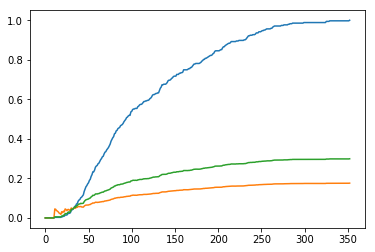

In [402]:
# plt.plot(result_df['Recall'], result_df['Precision'])
result_df['Recall'].plot()
result_df['Precision'].plot()
result_df['F1'].plot()

In [305]:
# input_types = ["returns", "euclidean-distances", "symmetrical-kl-divergence", "asymmetrical-kl-divergence"]
input_types = ["returns"]
dataset_types = ["training", "validation", "test"]

mul_lr = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-10, 10))), 
                        penalty='l2',
                        scoring='roc_auc',
                        random_state=777,
                        max_iter=10000,
                        fit_intercept=True,
                        solver='newton-cg',
                        tol=10)

log_clf = LogisticRegression(multi_class='multinomial', solver='newton-cg')

# lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
#             0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
#             6, 7, 8, 9, 10]

lam_list = [1]

for input_type in input_types:
    print("-----------------------------------------------------------------------------")
    print("%s" % input_type)
        
    for lambda_multiplier in lam_list:
        print("Processing lambda = %.5f" % lambda_multiplier)
        S_training_df, S_validation_df, S_test_df = get_sparse_dfs(input_type, 
                                                                   lambda_multiplier, 
                                                                   Y_training_anomalies, 
                                                                   Y_validation_anomalies, 
                                                                   Y_test_anomalies)
        X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test(S_training_df, 
                                                                            S_validation_df, 
                                                                            S_test_df)
        log_clf.fit(X_train, y_train)                
        print('Accuracy of LR classifier on Training set: {:.2f}'.format(log_clf.score(X_train, y_train).mean()))
        print('Accuracy of LR classifier on Validation set: {:.2f}'.format(log_clf.score(X_val, y_val).mean()))        
        print('Accuracy of LR classifier on Test set: {:.2f}'.format(log_clf.score(X_test, y_test).mean()))

        y_train_pred = log_clf.predict(X_train)
        y_val_pred = log_clf.predict(X_val)
        y_test_pred = log_clf.predict(X_test)

        training_confusion_matrix = confusion_matrix(y_train, y_train_pred)
        validation_confusion_matrix = confusion_matrix(y_val, y_val_pred)
        test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

        print("Training Confusion Matrix")
        print(training_confusion_matrix)

        print("Validation Confusion Matrix")
        print(validation_confusion_matrix)

        print("Test Confusion Matrix")
        print(test_confusion_matrix)
        
        print(classification_report(y_test, y_test_pred))

#         score = cross_val_score(log_clf, X_train, y_train, cv=10)
#         print('Accuracy of LR classifier on Training set: {:.2f}'.format(score.mean()))

#         score = cross_val_score(log_clf, X_val, y_val, cv=10)
#         print('Accuracy of LR classifier on Validation set: {:.2f}'.format(score.mean()))

#         score = cross_val_score(log_clf, X_test, y_test, cv=10)
#         print('Accuracy of LR classifier on Test set: {:.2f}'.format(score.mean()))        
        
        print()

-----------------------------------------------------------------------------
returns
Processing lambda = 1.00000
Accuracy of LR classifier on Training set: 0.82
Accuracy of LR classifier on Validation set: 0.93
Accuracy of LR classifier on Test set: 0.94
Training Confusion Matrix
[[  15  153   14]
 [  15 1580   12]
 [  14  136   11]]
Validation Confusion Matrix
[[  0  21   0]
 [  0 464   0]
 [  0  14   0]]
Test Confusion Matrix
[[  0  15   0]
 [  0 470   0]
 [  0  15   0]]
             precision    recall  f1-score   support

         -1       0.00      0.00      0.00        15
          0       0.94      1.00      0.97       470
          1       0.00      0.00      0.00        15

avg / total       0.88      0.94      0.91       500




C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [198]:
from sklearn.metrics import confusion_matrix
y_train_pred = searchCV.predict(X_train)
y_val_pred = searchCV.predict(X_val)
y_test_pred = searchCV.predict(X_test)

training_confusion_matrix = confusion_matrix(y_train, y_train_pred)
validation_confusion_matrix = confusion_matrix(y_val, y_val_pred)
test_confusion_matrix = confusion_matrix(y_test, y_test_pred)

print("Training Confusion Matrix")
print(training_confusion_matrix)

print("Validation Confusion Matrix")
print(validation_confusion_matrix)

print("Test Confusion Matrix")
print(test_confusion_matrix)

NameError: name 'get_output_root_dir' is not defined

In [33]:
sp500_df = pd.read_csv(r'C:\phd\input\rpca\GSPC.csv')
sp500_df = sp500_df.set_index('Date')
sp500_df.index = pd.to_datetime(sp500_df.index)
df_ = sp500_df[['Adj Close']].copy()
df_returns = np.log(df_/df_.shift())
sp500_returns_df = df_returns.iloc[1:].copy()
sp500_returns_df.columns = ['Return']
sp500_returns_df['Adj Close'] = df_.ix[sp500_returns_df.index]['Adj Close']

We are using 66% of dates as training set.  17% is used for validation and 17% is used for testing.

In [65]:
def train_test_split(df, training_pct, validation_pct):
    training_set_end_idx = int(df.shape[0] * training_pct)
    validation_set_end_idx = int(df.shape[0] * (training_pct+ validation_pct))
    m_training = df[0:training_set_end_idx].copy()
    m_validation = df[training_set_end_idx:validation_set_end_idx].copy()
    m_test = df[validation_set_end_idx:].copy()
    return m_training, m_validation, m_test

def get_sp500_anomalies(df, threshold):
    df_anomalies = df.copy()
    df_anomalies.drop('Adj Close', axis=1, inplace=True)
    df_anomalies[abs(df_anomalies) < threshold] = 0
    df_anomalies[df_anomalies < 0] = -1
    df_anomalies[df_anomalies > 0] = +1
    return df_anomalies

def plot_sp500(training_df, validation_df, test_df):
    fig, axes = plt.subplots(ncols=3, figsize = (20, 6))
    axes[0].plot(training_df.index, training_df['Adj Close'])
    axes[0].set_title('Training S&P 500 Adj Close')
    axes[0].xaxis_date()
    axes[0].set_ylim(600, 3000)
    date_format = mdates.DateFormatter('%m/%y')
    axes[0].xaxis.set_major_formatter(date_format)

    axes[1].plot(validation_df.index, validation_df['Adj Close'])
    axes[1].set_title('Validation S&P 500 Adj Close')
    axes[1].xaxis_date()
    axes[1].set_ylim(600, 3000)
    axes[1].xaxis.set_major_formatter(date_format)

    axes[2].plot(test_df.index, test_df['Adj Close'])
    axes[2].set_title('Test S&P 500 Adj Close')
    axes[2].xaxis_date()
    axes[2].set_ylim(600, 3000)
    axes[2].xaxis.set_major_formatter(date_format)
    
def plot_sp500_anomalies(training_df, validation_df, test_df):
    fig, axes = plt.subplots(ncols=3, figsize = (20, 6))
    axes[0].plot(training_df.index, training_df)
    axes[0].set_title('Training S&P 500 Anomalies')
    axes[0].xaxis_date()
    date_format = mdates.DateFormatter('%m/%y')
    axes[0].xaxis.set_major_formatter(date_format)

    axes[1].plot(validation_df.index, validation_df)
    axes[1].set_title('Validation S&P 500 Anomalies')
    axes[1].xaxis_date()
    axes[1].xaxis.set_major_formatter(date_format)

    axes[2].plot(test_df.index, test_df)
    axes[2].set_title('Test S&P 500 Anomalies')
    axes[2].xaxis_date()
    axes[2].xaxis.set_major_formatter(date_format)
    
def get_output_root_dir(dataset_type):
    output_root_dir = None
    if "training" == dataset_type:
        output_root_dir = r'C:\phd\rpca\output\returns\training'
    elif "validation" == dataset_type:
        output_root_dir = r'C:\phd\rpca\output\returns\validation'
    else:
        output_root_dir = r'C:\phd\rpca\output\returns\test'
    return output_root_dir

def get_euclidean_output_root_dir(dataset_type):
    output_root_dir = None
    if "training" == dataset_type:
        output_root_dir = r'C:\phd\rpca\output\euclidean-distances\training'
    elif "validation" == dataset_type:
        output_root_dir = r'C:\phd\rpca\output\euclidean-distances\validation'
    else:
        output_root_dir = r'C:\phd\rpca\output\euclidean-distances\test'
    return output_root_dir

def get_kl_output_root_dir(dataset_type):
    output_root_dir = None
    if "training" == dataset_type:
        output_root_dir = r'C:\phd\rpca\output\kl-divergence\training'
    elif "validation" == dataset_type:
        output_root_dir = r'C:\phd\rpca\output\kl-divergence\validation'
    else:
        output_root_dir = r'C:\phd\rpca\output\kl-divergence\test'
    return output_root_dir

def get_sp500_anomalies_by_dataset_type(dataset_type):
    if "training" == dataset_type:
        return sp500_training_anomalies
    elif "validation" == dataset_type:
        return sp500_validation_anomalies
    else:
        return sp500_test_anomalies    
    
def load_sparse_matrices(root_dir, lam):
    file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_S.npz')
    sparse_matrix = scipy.sparse.load_npz(file_path)
    dense_matrix = sparse_matrix.todense()    
    return sparse_matrix, dense_matrix    

In [70]:
sp500_training_df, sp500_validation_df, sp500_test_df = train_test_split(sp500_returns_df, 0.66, 0.17)

threshold = 0.02
sp500_training_anomalies = get_sp500_anomalies(sp500_training_df, threshold)
sp500_validation_anomalies = get_sp500_anomalies(sp500_validation_df, threshold)
sp500_test_anomalies = get_sp500_anomalies(sp500_test_df, threshold)

In [73]:
D.shape

(503, 549)

#### Plot S&P 500 Training, Validation, and Test

In [5]:
# plot_sp500(sp500_training_df, sp500_validation_df, sp500_test_df)
# plot_sp500_anomalies(sp500_training_anomalies, sp500_validation_anomalies, sp500_test_anomalies)

### $1^{st}$ order - Returns 

In [6]:
training_root_dir = r'C:\phd\rpca\output\returns\training'
validation_root_dir = r'C:\phd\rpca\output\returns\validation'
test_root_dir = r'C:\phd\rpca\output\returns\test'

In [78]:
lam = 0.01
S, D = load_sparse_matrices(r'C:\phd\rpca\output\kl-divergence\training', lam)
D.shape[0]*D.shape[1]

3818116

In [20]:
S_df = pd.DataFrame(D)

In [27]:
sum(S_df[abs(S_df) < 0.01].count())

166504

In [17]:
ticker_threshold = 0.03
D[abs(D) < ticker_threshold] = 0
D[D < 0] = -1
D[D > 0] = +1
nnz = np.sum(abs(D), axis=1)
S_df = pd.DataFrame(nnz)

In [37]:
np.sum(abs(nnz))

46268.0

In [335]:
# summary = S_df['NNZ'].describe(percentiles=[0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85])
# summary['15%']
# sp500_training_anomalies.ix[S_df.index]['Return']

In [365]:
S_df = pd.DataFrame(nnz)
S_df.columns = ['NNZ']
S_df.index = pd.to_datetime(sp500_validation_anomalies.index)
S_df['NNZ_PCT_CHGN'] = (S_df['NNZ']/S_df['NNZ'].shift() - 1)
S_df.fillna(0, inplace=True)

S_df['NNZ_MA_5D'] = S_df['NNZ'].rolling(5).mean()
S_df.fillna(0, inplace=True)

S_df['NNZ_MA_5D_CHGN'] = (S_df['NNZ_MA_5D']/S_df['NNZ_MA_5D'].shift() - 1)
S_df.replace([np.inf, -np.inf], np.nan, inplace=True)
S_df.fillna(0, inplace=True)


# Strategy 1: If the % change is NNZ greater than 25%, it is an anamoly
S_df['SP500_RETURN'] = sp500_validation_anomalies.ix[S_df.index]['Return']
S_df.SP500_RETURN = S_df.SP500_RETURN.astype(int)
S_df['SP500_ANOMALIES'] = np.abs(S_df['SP500_RETURN'])

# several conditions are used to map the NNZ into 1 number
# S_df['CONSTITUENT_ANOMALIES'] = np.where(S_df['NNZ'] < 175, 0, 
#                              np.where((S_df['NNZ'] >= 350) | (S_df['NNZ_MA_5D'] >= 350), 1, 
#                                       np.where((abs(S_df['NNZ_MA_5D_CHGN']) > 0.1) | (abs(S_df['NNZ_PCT_CHGN']) > 0.15), 1, 0)))  # S_df['NNZ'].median()

S_df['CONSTITUENT_ANOMALIES'] = np.where((abs(S_df['NNZ_MA_5D_CHGN']) > 0.1) & (abs(S_df['NNZ_PCT_CHGN']) > 0.15), 1, 0)
S_df['LAMBDA'] = lam

In [364]:
S_df.to_csv(r'C:\phd\rpca\debug\S_validation_dataframe.csv')

In [336]:
# S_df['MA_5'] = S_df['NNZ'].rolling(5).mean()
# S_df['MA_10'] = S_df['NNZ'].rolling(10).mean()

# temp = (S_df/S_df.shift() - 1)

# temp.head()

# S_df.head(n=15)

# sp500_training_anomalies.tail()

# S_df.plot()

In [317]:
def plot_Sparse_anomalies(training_df):
    fig, axes = plt.subplots(ncols=3, figsize = (20, 6))
    axes[0].plot(training_df.index, training_df['CHGN_GT_25_PCT'])
    axes[0].set_title('Training Sparse Anomalies')
    axes[0].xaxis_date()
    date_format = mdates.DateFormatter('%m/%y')
    axes[0].xaxis.set_major_formatter(date_format)

    axes[1].plot(training_df.index, training_df['CHGN_GT_25_PCT'])
    axes[1].set_title('Validation Sparse Anomalies')
    axes[1].xaxis_date()
    axes[1].xaxis.set_major_formatter(date_format)

    axes[2].plot(training_df.index, training_df['CHGN_GT_25_PCT'])
    axes[2].set_title('Test Sparse Anomalies')
    axes[2].xaxis_date()
    axes[2].xaxis.set_major_formatter(date_format)    

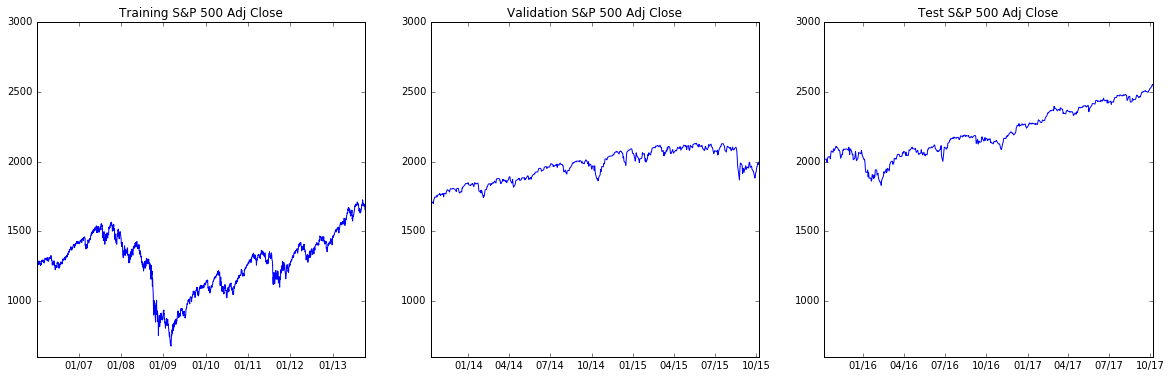

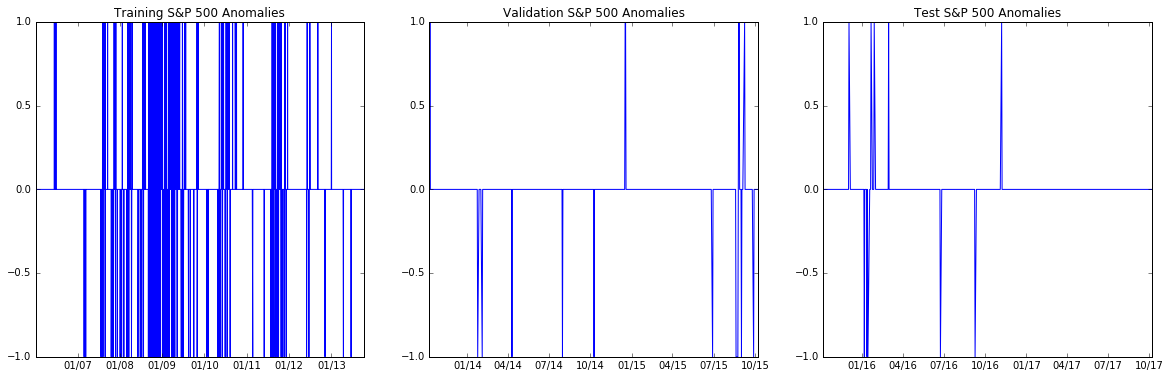

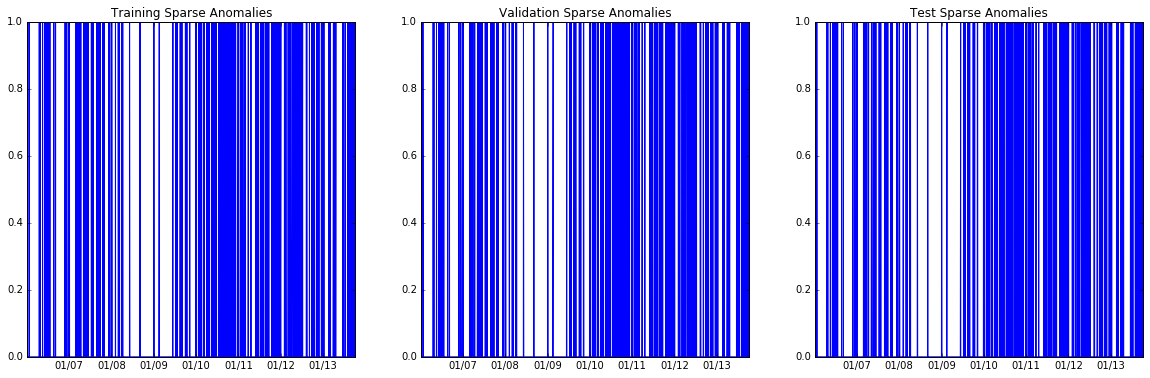

In [318]:
plot_sp500(sp500_training_df, sp500_validation_df, sp500_test_df)
plot_sp500_anomalies(sp500_training_anomalies, sp500_validation_anomalies, sp500_test_anomalies)
plot_Sparse_anomalies(S_df)

In [350]:
cm = confusion_matrix(S_df['SP500_ANOMALIES'], S_df['CONSTITUENT_ANOMALIES'])

In [351]:
TP = cm[1,1]
TN = cm[0,0]
FP = cm[0,1]
FN = cm[1,0]

### <font color="red">DEBUGGING SECTION</font>

In [49]:
lam_list = [19, 17, 15, 13, 11, 9, 7, 5, 3, 1, 
            0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 
            0.02, 0.0175, 0.015, 0.0125, 0.010, 0.0075, 0.002]
dataset_types = ["test"]
for dataset_type in dataset_types:
    output_root_dir = get_output_root_dir(dataset_type)
    for _lam in lam_list:    
        S, D = load_sparse_matrices(output_root_dir, _lam)
        D_df = pd.DataFrame(D)
        filename = r'C:\phd\rpca\output\returns\debug\\' + dataset_type + r'\lambda_' + str(_lam) + "_" + dataset_type + ".csv"
        D_df.to_csv(filename)

C:\phd\rpca\output\returns\test\lambda_19_S.npz
C:\phd\rpca\output\returns\test\lambda_17_S.npz
C:\phd\rpca\output\returns\test\lambda_15_S.npz
C:\phd\rpca\output\returns\test\lambda_13_S.npz
C:\phd\rpca\output\returns\test\lambda_11_S.npz
C:\phd\rpca\output\returns\test\lambda_9_S.npz
C:\phd\rpca\output\returns\test\lambda_7_S.npz
C:\phd\rpca\output\returns\test\lambda_5_S.npz
C:\phd\rpca\output\returns\test\lambda_3_S.npz
C:\phd\rpca\output\returns\test\lambda_1_S.npz
C:\phd\rpca\output\returns\test\lambda_0.9_S.npz
C:\phd\rpca\output\returns\test\lambda_0.8_S.npz
C:\phd\rpca\output\returns\test\lambda_0.7_S.npz
C:\phd\rpca\output\returns\test\lambda_0.6_S.npz
C:\phd\rpca\output\returns\test\lambda_0.5_S.npz
C:\phd\rpca\output\returns\test\lambda_0.4_S.npz
C:\phd\rpca\output\returns\test\lambda_0.3_S.npz
C:\phd\rpca\output\returns\test\lambda_0.2_S.npz
C:\phd\rpca\output\returns\test\lambda_0.1_S.npz
C:\phd\rpca\output\returns\test\lambda_0.05_S.npz
C:\phd\rpca\output\returns\test\la

In [57]:
output_root_dir = get_output_root_dir("test")

S, D = load_sparse_matrices(output_root_dir, 0.01)
D[abs(D) < 0.02] = 0
nnz = np.count_nonzero(D, axis=1)
df = pd.DataFrame(nnz)
np.sum(df)

C:\phd\rpca\output\returns\test\lambda_0.02_S.npz


0    46268
dtype: int64

In [80]:
lam_list = [19, 17, 15, 13, 11, 9, 7, 5, 3, 1, 
            0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 
            0.02, 0.0175, 0.015, 0.0125, 0.010, 0.0075, 0.002]
dataset_types = ["test"]
for dataset_type in dataset_types:
    output_root_dir = get_output_root_dir(dataset_type)
    for _lam in lam_list:    
        S, D = load_sparse_matrices(output_root_dir, _lam)
        D[abs(D) < 0.01] = 0
        nnz = np.count_nonzero(D, axis=1)
        df = pd.DataFrame(nnz)
        total_nnz = np.sum(df)
        print("%d" % total_nnz)

5
7
10
18
38
92
226
593
2156
37041
44349
52473
60659
67747
72908
77202
83253
91658
111388
112023
112023
112023
112023
112023
112023
112023
112023


In [81]:
lam_list = [19, 17, 15, 13, 11, 9, 7, 5, 3, 1, 
            0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 
            0.02, 0.0175, 0.015, 0.0125, 0.010, 0.0075, 0.002]

training_root_dir = r'C:\phd\rpca\output\returns\training'
validation_root_dir = r'C:\phd\rpca\output\returns\validation'
test_root_dir = r'C:\phd\rpca\output\returns\test'

# -------------------------------------------------------------
# changes less than 4% are considered not anomalous.
# TODO: This can be later enhanced with sector ETFs
# -------------------------------------------------------------
ticker_threshold = 0.02

dataset_types = ["training", "validation", "test"]

result_df = pd.DataFrame(columns=['datatype', 'lambda', 'TP', 'TN', 'FP', 'FN']) 

i = 0

for dataset_type in dataset_types:
    for _lam in lam_list:    
        output_root_dir = get_output_root_dir(dataset_type)
        S, D = load_sparse_matrices(output_root_dir, _lam)
        D[abs(D) < ticker_threshold] = 0
        
        # number of non zero elements per day
        nnz = np.count_nonzero(D, axis=1)

        # calculate NNZ - number of non zero elements
        # increase or decrease on a daily basis
        sp500_anomalies = get_sp500_anomalies_by_dataset_type(dataset_type)
        S_df = pd.DataFrame(nnz)
        S_df.columns = ['NNZ']
        S_df.index = pd.to_datetime(sp500_anomalies.index)
        S_df['NNZ_PCT_CHGN'] = (S_df['NNZ']/S_df['NNZ'].shift() - 1)
        S_df.fillna(0, inplace=True)

        # to avoid daily fluctuations, we leverage moving average
        # because these are liquid stocks we only use a week, 5 trading days.
        # also calculate the fluctuations in these
        S_df['NNZ_MA_5D'] = S_df['NNZ'].rolling(5).mean()
        S_df.fillna(0, inplace=True)

        S_df['NNZ_MA_5D_CHGN'] = (S_df['NNZ_MA_5D']/S_df['NNZ_MA_5D'].shift() - 1)
        S_df.replace([np.inf, -np.inf], np.nan, inplace=True)
        S_df.fillna(0, inplace=True)


        # Strategy 1: If the % change is S&P 500 is greater than 2.5%, it is an anamolous return
        S_df['SP500_RETURN'] = sp500_anomalies.ix[S_df.index]['Return']
        S_df.SP500_RETURN = S_df.SP500_RETURN.astype(int)
        S_df['SP500_ANOMALIES'] = np.abs(S_df['SP500_RETURN'])

        # -----------------------------------------------------------------------------------------------------------------------
        # several conditions are used to map the NNZ into 1 number
        # 175 is approximately 33% of 540 constituents.  Note, we keep the constituents consistent across years.
        # Index change is avoided.
        # 350 is 70% of 500.  So if a large number of non-zero elements are there then the constituents are anomalous.
        # We also want to limit to large changes.  So the change in moving average of NNZ and actual change in NNZ is taken 
        # into account too.
        # All these determine if the contituents are anomalous.
        # -----------------------------------------------------------------------------------------------------------------------
        S_df['CONSTITUENT_ANOMALIES'] = np.where((abs(S_df['NNZ_MA_5D_CHGN']) > 0.1) & (abs(S_df['NNZ_PCT_CHGN']) > 0.15), 1, 0)
        S_df['LAMBDA'] = lam
        S_df['DATASET_TYPE'] = dataset_type

        # confusion matrix
        cm = confusion_matrix(S_df['SP500_ANOMALIES'], S_df['CONSTITUENT_ANOMALIES'])

        TP = cm[1,1]
        TN = cm[0,0]
        FP = cm[0,1]
        FN = cm[1,0]

        result_df.loc[i] = [dataset_type, _lam, TP, TN, FP, FN]

        filename = r'C:\phd\rpca\results\returns\\' + dataset_type + r'\lambda_' + str(_lam) + "_" + dataset_type + ".csv"
        S_df.to_csv(filename)
        
        i = i + 1
        
result_df.to_csv(r'C:\phd\rpca\results\returns\result_df.csv')

In [82]:
result_df.head()

datatype  lambda   TP      TN    FP     FN
0  training    19.0  0.0  1741.0   0.0  213.0
1  training    17.0  0.0  1741.0   0.0  213.0
2  training    15.0  0.0  1741.0   0.0  213.0
3  training    13.0  0.0  1740.0   1.0  213.0
4  training    11.0  2.0  1731.0  10.0  211.0